In [0]:
import time
import os
import random
import math
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from PIL import Image
import pandas as pd
import progressbar


In [0]:
plt.ion()

In [0]:
def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp
def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes2 = to_2d_tensor(boxes2)

    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)

    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, im_sizes, theta=0.85):
    preds = to_2d_tensor(preds.clone())

    targets = to_2d_tensor(targets.clone())
    IoU = compute_IoU(preds, targets)

    corr = (IoU >= theta).sum()
    return corr.item() / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum/self.cnt

In [0]:
image_dir = 'Enter image directory here'

In [0]:
train_csv = pd.read_csv('Enter location of trining csv')

In [0]:
train_csv.shape

(24000, 5)

In [0]:
train_csv[:10]

,image_name,x1,x2,y1,y2
0,JPEG_20160517_140621_1000651031832.png,78,446,83,422
1,1473231510890DeeplearnS11456.png,73,567,146,351
2,1476881557883Untitled1.png,13,561,124,362
3,1474264827890cobalt-beyond-the-sea-maxi-dress3...,0,640,140,330
4,JPEG_20160711_113321_1000235741992.png,217,442,65,465
5,147954714706311.png,48,592,47,480
6,JPEG_20161117_154532_1000146348308.png,160,591,127,359
7,1469052256414DSC_0653.png,37,640,0,480
8,14581478747652.png,197,438,113,364
9,JPEG_20161207_165644_1000961805303.png,206,448,143,364


In [0]:
from tqdm import tqdm

class datasets(Dataset):
  def __init__(self,start,size,transform=None,train=True):
    id_to_path={}
    id_to_box={}

    self.train=train
    for i in tqdm(range(size)):
      id = start+i;
      path = image_dir + train_csv['image_name'][id]
      id_to_path[int(i)]=path
      x1 = train_csv['x1'][id]/640*224
      x2 = train_csv['x2'][id]/640*224
      y1 = train_csv['y1'][id]/480*224
      y2 = train_csv['y2'][id]/480*224
      
      box = [x1, y1, x2 ,y2]
      id_to_box[int(i)] = box

    self.imgs = [(id_to_path[j], id_to_box[j])
                        for j in range(size)]


    if transform is None:
      self.transform = transforms.Compose([
                  transforms.Resize(224,224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
              ])
      
    else:
      self.transform = transform
  
  def __getitem__(self, index):
    
      path, box=self.imgs[index]
      im=Image.open(path).convert('RGB')
      
      box=np.array(box, dtype='float32')
      
      im_size = np.array(im.size, dtype='float32')    
      
      im=self.transform(im)
     
      

      return im,box,im_size
    
  def __len__(self):
    return len(self.imgs)
  

In [0]:
train_dataset=datasets(0,23000, train=True)

100%|██████████| 23000/23000 [00:01<00:00, 12073.08it/s]


In [0]:
test_dataset=datasets(23000,1000, train=False)

100%|██████████| 1000/1000 [00:00<00:00, 10842.23it/s]


In [0]:
def imshow(img, gt_box, pred_box):
    plt.imshow(img)
    
    def draw_box(box, color='green'):
        x, y, w, h = to_2d_tensor(box)[0]
        
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        plt.gca().add_patch(
            plt.Rectangle((x, y), w-x, h-y,
                          fill=False, edgecolor=color, linewidth=4, alpha=1)
        )

#     draw_box(gt_box)
    
    draw_box(pred_box, 'red')


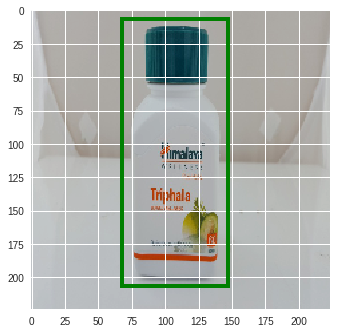

In [0]:
ind = random.choice(range(len(train_dataset)))
im, box, im_size = train_dataset[ind]

box = to_2d_tensor(box)

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(inp, box[0])

In [0]:
trainLoader=torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True)
testLoader=torch.utils.data.DataLoader(test_dataset, batch_size=64)
dataloaders={'train':trainLoader,'test':testLoader}

In [0]:
model=models.resnet34(pretrained=False)

model

In [0]:
fc_in_size = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(fc_in_size,4))               
model = model.cuda()
criterion = nn.SmoothL1Loss().cuda()

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [0]:
epoch_loss = {'train': [], 'test': []}
epoch_acc = {'train': [], 'test': []}

In [0]:
saveChk(-1,0.0,0,model.state_dict(),1e-3,epoch_loss,epoch_acc)

In [0]:
def saveChk(best_epoch,best_acc,last_epoch,best_model_state,lr,epoch_loss,epoch_acc):
  chkpoint={"best_epoch":best_epoch,
          "best_acc":best_acc,
          "last_epoch":last_epoch,
          "best_model_state":model.state_dict(),
          "lr":lr,
          "epoch_loss":epoch_loss,
          "epoch_acc":epoch_acc}
  torch.save(chkpoint,'Enter Checkpoint location')

def loadChk():
  return torch.load('Enter checkpoint location')


In [0]:
chkpt=loadChk()

In [0]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [0]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [0]:
best_model_state = chkpt['best_model_state']
best_epoch = chkpt['best_epoch']
best_acc = chkpt['best_acc']
epochs=chkpt['last_epoch']+25

In [0]:
epoch_loss = chkpt['epoch_loss']
epoch_acc = chkpt['epoch_acc']

In [0]:
for epoch in range(chkpt['last_epoch'],epochs):
    accs = AverageMeter()
    losses = AverageMeter()
    for phase in ('train', 'test'):
        if phase == 'train':
            scheduler.step()
            model.train()
        else:
            model.eval()
            
        end = time.time()
        bar = progressbar.ProgressBar()
        if phase == 'test':
          with torch.no_grad():
            for ims, boxes, im_sizes in bar(dataloaders[phase]):
              boxes = to_2d_tensor(boxes)

            
              inputs = Variable(ims.cuda())
              targets = Variable(boxes.cuda())
            
              optimizer.zero_grad()
            
            
              outputs = model(inputs)

              loss = criterion(outputs, targets)
              acc = compute_acc(outputs.data.cpu(), targets.data.cpu(), im_sizes)

            
              nsample = inputs.size(0)
              accs.update(acc, nsample)
              losses.update(loss.item(), nsample)
              
            if phase == 'test' and accs.avg > best_acc:
              best_acc = accs.avg
              best_epoch = epoch
              best_model_state = model.state_dict()
              
        else:
          
          for ims, boxes, im_sizes in bar(dataloaders[phase]):
            boxes = to_2d_tensor(boxes)

            
            inputs = Variable(ims.cuda())
            targets = Variable(boxes.cuda())
            
            optimizer.zero_grad()
            
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            acc = compute_acc(outputs.data.cpu(), targets.data.cpu(), im_sizes)

            
            nsample = inputs.size(0)
            accs.update(acc, nsample)
            losses.update(loss.item(), nsample)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
        
        
            
        elapsed_time = time.time() - end
        print('[{}]\tEpoch: {}/{}\tLoss: {:.4f}\tAcc: {:.2%}\tTime: {:.3f}'.format(
            phase, epoch+1, epochs, losses.avg, accs.avg, elapsed_time))
        epoch_loss[phase].append(losses.avg)
        epoch_acc[phase].append(accs.avg)
        
    print('[Info] best test acc: {:.2%} at {}th epoch'.format(best_acc, best_epoch))
    saveChk(best_epoch,best_acc,epoch,best_model_state,get_lr(optimizer),epoch_loss, epoch_acc)
    

100% (360 of 360) |######################| Elapsed Time: 0:11:09 Time:  0:11:09


[train]	Epoch: 15/39	Loss: 14.6151	Acc: 9.31%	Time: 670.126


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 15/39	Loss: 14.4363	Acc: 9.78%	Time: 14.459
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:09 Time:  0:11:09


[train]	Epoch: 16/39	Loss: 10.7937	Acc: 19.64%	Time: 670.103


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 16/39	Loss: 10.6869	Acc: 20.17%	Time: 14.424
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:09 Time:  0:11:09


[train]	Epoch: 17/39	Loss: 9.1230	Acc: 28.53%	Time: 669.619


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 17/39	Loss: 9.0832	Acc: 28.82%	Time: 14.294
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:08 Time:  0:11:08


[train]	Epoch: 18/39	Loss: 8.3942	Acc: 33.26%	Time: 669.020


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 18/39	Loss: 8.2728	Acc: 34.60%	Time: 14.252
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:08 Time:  0:11:08


[train]	Epoch: 19/39	Loss: 7.8338	Acc: 37.41%	Time: 668.568


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 19/39	Loss: 7.7323	Acc: 38.56%	Time: 14.236
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:06 Time:  0:11:06


[train]	Epoch: 20/39	Loss: 7.4308	Acc: 39.38%	Time: 666.628


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 20/39	Loss: 7.3324	Acc: 40.51%	Time: 14.220
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:06 Time:  0:11:06


[train]	Epoch: 21/39	Loss: 7.2511	Acc: 41.20%	Time: 667.111


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 21/39	Loss: 7.1411	Acc: 42.53%	Time: 14.212
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:08 Time:  0:11:08


[train]	Epoch: 22/39	Loss: 6.8731	Acc: 44.10%	Time: 668.632


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 22/39	Loss: 6.7571	Acc: 45.50%	Time: 14.425
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:09 Time:  0:11:09


[train]	Epoch: 23/39	Loss: 6.6781	Acc: 45.63%	Time: 669.707


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 23/39	Loss: 6.5823	Acc: 46.76%	Time: 14.312
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:08 Time:  0:11:08


[train]	Epoch: 24/39	Loss: 6.0893	Acc: 50.66%	Time: 669.098


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 24/39	Loss: 5.9900	Acc: 51.86%	Time: 14.280
[Info] best test acc: 51.93% at 14th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:09 Time:  0:11:09


[train]	Epoch: 25/39	Loss: 5.9865	Acc: 51.35%	Time: 669.584


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 25/39	Loss: 5.8819	Acc: 52.60%	Time: 14.282
[Info] best test acc: 52.60% at 24th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:07 Time:  0:11:07


[train]	Epoch: 26/39	Loss: 5.8588	Acc: 52.33%	Time: 667.875


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 26/39	Loss: 5.7591	Acc: 53.60%	Time: 14.249
[Info] best test acc: 53.60% at 25th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:07 Time:  0:11:07


[train]	Epoch: 27/39	Loss: 5.7968	Acc: 53.14%	Time: 668.120


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 27/39	Loss: 5.6965	Acc: 54.40%	Time: 14.364
[Info] best test acc: 54.40% at 26th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:07 Time:  0:11:07


[train]	Epoch: 28/39	Loss: 5.7166	Acc: 53.69%	Time: 668.097


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 28/39	Loss: 5.6200	Acc: 54.90%	Time: 14.222
[Info] best test acc: 54.90% at 27th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:07 Time:  0:11:07


[train]	Epoch: 29/39	Loss: 5.7010	Acc: 53.78%	Time: 668.175


100% (16 of 16) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


[test]	Epoch: 29/39	Loss: 5.6045	Acc: 54.99%	Time: 14.530
[Info] best test acc: 54.99% at 28th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:06 Time:  0:11:06


[train]	Epoch: 30/39	Loss: 5.6279	Acc: 54.40%	Time: 667.533


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 30/39	Loss: 5.5331	Acc: 55.61%	Time: 14.281
[Info] best test acc: 55.61% at 29th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:08 Time:  0:11:08


[train]	Epoch: 31/39	Loss: 5.6020	Acc: 54.40%	Time: 668.683


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 31/39	Loss: 5.5062	Acc: 55.60%	Time: 14.427
[Info] best test acc: 55.61% at 29th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:06 Time:  0:11:06


[train]	Epoch: 32/39	Loss: 5.5003	Acc: 55.63%	Time: 667.514


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 32/39	Loss: 5.4064	Acc: 56.78%	Time: 14.306
[Info] best test acc: 56.78% at 31th epoch


100% (360 of 360) |######################| Elapsed Time: 0:11:06 Time:  0:11:06


[train]	Epoch: 33/39	Loss: 5.4785	Acc: 56.18%	Time: 667.011


100% (16 of 16) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


[test]	Epoch: 33/39	Loss: 5.3892	Acc: 57.30%	Time: 14.243
[Info] best test acc: 57.30% at 32th epoch


 60% (217 of 360) |#############         | Elapsed Time: 0:06:42 ETA:   0:04:24

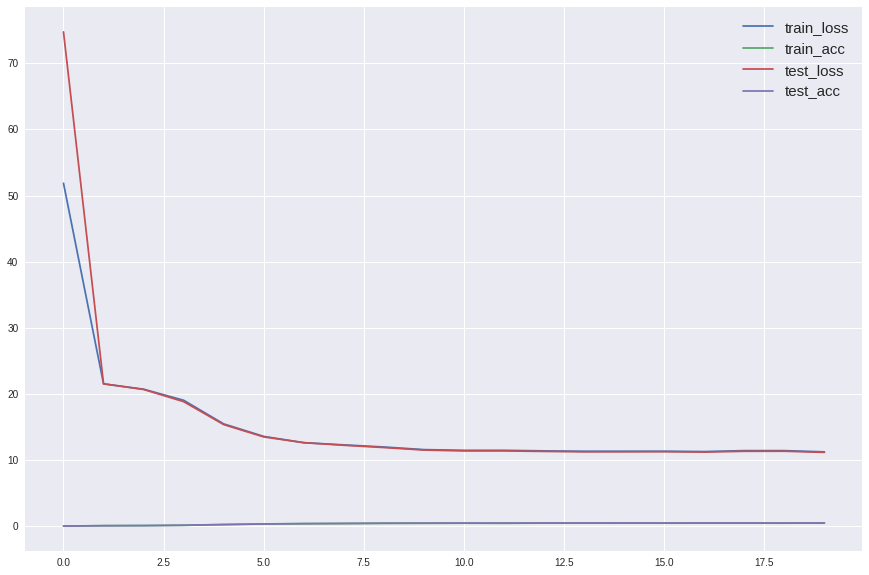

In [0]:
for phase in ('train', 'test'):
    plt.plot(range(len(epoch_loss[phase])), epoch_loss[phase], label=(phase + '_loss'))
    plt.plot(range(len(epoch_acc[phase])), epoch_acc[phase], label=(phase + '_acc'))
plt.legend(prop={'size': 15})

In [0]:
def plot_model(epoch_acc):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(range(1,len(epoch_acc['train'])+1),epoch_acc['train'])
    axs[0].plot(range(1,len(epoch_acc['test'])+1),epoch_acc['test'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(epoch_acc['train'])+1),len(epoch_acc['train'])/10)
    axs[0].legend(['train', 'val'], loc='best
    plt.savefig("model.png")

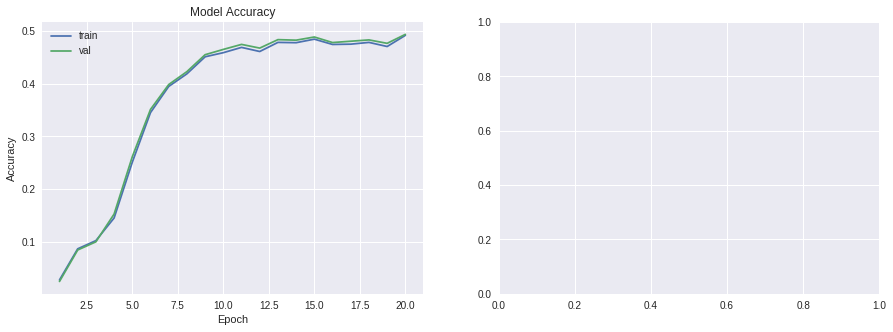

In [0]:
plot_model(epoch_acc)

In [0]:
ind = random.choice(range(len(test_dataset)))
im, box, im_size = test_dataset[ind]
path, _ = test_dataset.imgs[ind]
box = to_2d_tensor(box)[0]

[  6.65      17.733334 215.25     204.86667 ]
[224. 224.]


tensor([-0.1461, -0.1670,  0.3635, -0.2387]) tensor([  6.6500,  17.7333, 215.2500, 204.8667])


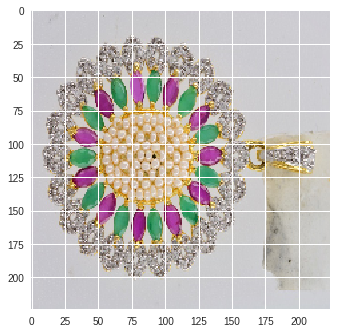

In [0]:
model=model.cpu()
pred_box = model(Variable(im.unsqueeze(0))).data[0].cpu()
print(pred_box,box)
ori_im = np.array(Image.open(path))

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(ori_im, box, pred_box)